In [1]:
import glob,os
from collections import Counter
from Bio import Seq,Alphabet
import numpy as np

def count_sites(consensus,ts_tv=1):
    norm_s=0 ## count synonymous sites
    norm_n=0 ## count non-synonymous sites
    
    for i in range(0,len(consensus),3): ## iterate over codons
        consensus_codon=consensus[i:i+3] ## get codon in consensus
        
        if '-' not in consensus_codon and 'N' not in consensus_codon: ## valid codon
            local_n=0
            local_s=0
            
            for site in range(3): ## for every codon position
                for state in ['A','C','T','G']: ## for every possible state
                    modified_codon=list(consensus_codon) ## turn consensus codon into list
                    modified_codon[site]=state ## modify base at site
                    
                    if modified_codon[site]!=consensus_codon[site]: ## if site doesn't match state with consensus codon
                        
                        mutation='%s%s'%(consensus_codon[site],state)
                        
                        kind=tstv[mutation]
                        scale=(1-1/(ts_tv+1)) if kind=='ts' else (1/(ts_tv+1))/2 ## twice as many transversions
#                         print(scale)
                        modified_codon=''.join(modified_codon) ## make codon string
                        
                        if gencode[consensus_codon]!=gencode[modified_codon]: ## nonsynonymous
                            norm_n+=scale ## add a third of a site (4 states - 1 observed consensus state) to non-synonymous
                            local_n+=scale
                        else: ## synonymous
                            norm_s+=scale ## add a third of a site (4 states - 1 observed consensus state) to synonymous
                            local_s+=scale
        
    return norm_n,norm_s

gencode = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'} ## universal code

tstv = {'AG': 'ts', 'GA': 'ts', 
        'CT': 'ts', 'TC': 'ts',
        'AC': 'tv', 'CA': 'tv', 
        'AT': 'tv', 'TA': 'tv', 
        'CG': 'tv', 'GC': 'tv', 
        'GT': 'tv', 'TG': 'tv'}

dnds_estimates={}

for aln in sorted(glob.glob('/Users/evogytis/Documents/manuscripts/narna-double-synonyms/data/*.fasta')):
    fname=os.path.basename(aln)
    
    data={}
    for line in open(aln,'r'):
        l=line.strip('\n')
        if '>' in l:
            name=l[1:]
        else:
            data[name]=l.replace('U','T')
    
    consensus=''.join([Counter([s[i] for s in data.values()]).most_common(1)[0][0] for i in range(len(l))]) ## generate consensus sequence
    
    norm_n,norm_s=count_sites(consensus,ts_tv=1)
    
    syn=0 ## count synonymous mutations
    nsyn=0 ## count non-synonymous mutations
    
    tv=0
    ts=0
    
    done=[]
    for seq in data: ## iterate over sequences
        s=data[seq] ## get sequence
        diffs=[[i,consensus[i:i+3],s[i:i+3]] for i in range(0,len(consensus),3) if data[seq][i:i+3]!=consensus[i:i+3]] ## get codons different between sequence and consensus codon

        for pair in diffs: ## for every difference
            idx,c,n=pair ## get site, consensus codon and changed codon
            
            if pair not in done: ## site+mutation not done previously
                done.append(pair) ## remember that this has been done

                if '-' not in c and '-' not in n and 'N' not in c and 'N' not in n: ## valid codon
                    
                    for a,b in zip(c,n): ## iterate over every pair of nucleotides in codon
                        if a!=b: ## doesn't match
                            if tstv['%s%s'%(a,b)]=='ts': ## check if transition or tranversion
                                ts+=1
                            else:
                                tv+=1
                    
                    if gencode[c]==gencode[n]: ## synonymous
                        syn+=1
                    else: ## non-synonymous
                        nsyn+=1
                        
#     print('\n%s'%(os.path.basename(aln)))
#     print('ts: %d\ttv: %d\tts/tv: %.3f'%(ts,tv,ts/tv))
#     print('N: %d\tS: %d'%(nsyn,syn)) ## raw counts
#     print('norm N: %.3f\tnorm S: %.3f'%(norm_n,norm_s)) ## normalisation counts
#     print('normalised N: %.3f\tnormalised S: %.3f'%(nsyn/norm_n,syn/norm_s))

    pN=(nsyn/norm_n)
    pS=(syn/norm_s)
    dnds_estimates[fname]=pN/pS
#     print('dN: %.3f\tdS: %.3f\nraw dN/dS: %.3f'%(pN,pS,pN/pS))
    print('%s\t%.3f\t%.3f'%(os.path.basename(aln),pN/pS,np.log(pN/pS)))

Culex_narnavirus_1_RdRp_fwd.fasta	0.186	-1.680
Culex_narnavirus_1_RdRp_rev.fasta	2.191	0.784
Culex_narnavirus_1_Robin_fwd.fasta	0.807	-0.214
Culex_narnavirus_1_Robin_rev.fasta	1.645	0.498
ZhejiangMosquitoVirus3_RdRp_fwd.fasta	0.168	-1.783
ZhejiangMosquitoVirus3_RdRp_rev.fasta	1.495	0.402
ZhejiangMosquitoVirus3_Robin_candidate_fwd.fasta	0.645	-0.439
ZhejiangMosquitoVirus3_Robin_candidate_rev.fasta	1.322	0.279


In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec

import baltic as bt
# import textwrap as tw

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

ll=bt.loadNewick('/Users/evogytis/Documents/manuscripts/narna-batman/NarnaLikeRdRps.newick')
ll.treeStats()


Tree height: 1.405821
Tree length: 5.372253
strictly bifurcating tree

Numbers of objects in tree: 125 (62 nodes and 63 leaves)



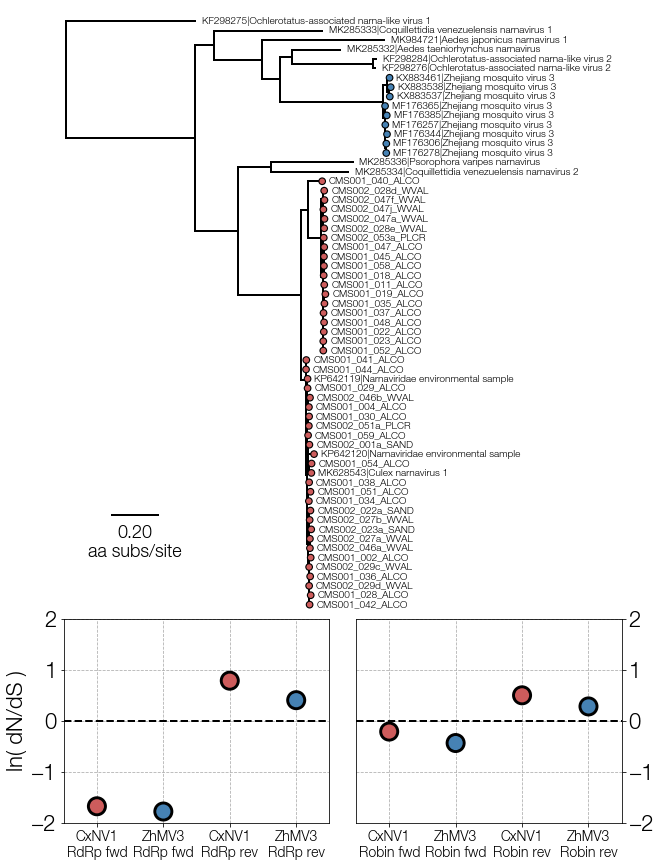

In [3]:
fig = plt.subplots(figsize=(10,15),facecolor='w')

gs = GridSpec(2,2,height_ratios=[3,1],hspace=0.0,wspace=0.1)

ax=plt.subplot(gs[0,:])

culex_narnavirus_1=lambda k: k.is_leaf() and any([k.name.startswith(acc) for acc in ['MK628543','KP642120','KP642119','CMS00']])

zhejiang_mosquito_virus_3=lambda k: k.is_leaf() and 'Zhejiang mosquito virus 3' in k.name

ll.plotPoints(ax,target=culex_narnavirus_1,size=30,colour='indianred')
ll.plotPoints(ax,target=zhejiang_mosquito_virus_3,size=30,colour='steelblue')

ll.plotTree(ax)
# ax.set_xlabel('amino acid subs/site')
[ax.spines[loc].set_visible(False) for loc in ax.spines]


for k in ll.getExternal():
#     if culex_narnavirus_1(k)==False and zhejiang_mosquito_virus_3(k)==False:
    ax.text(k.height+0.03,k.y,'|'.join(k.name.split('|')[:2]),va='center',ha='left',size=10)

ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

L=0.2
x=0.2
y=10

ax.plot([x,x+L],[y,y],lw=2,color='k')
ax.text(x+L/2,y-1,'%.2f\naa subs/site'%(L),ha='center',va='top',size=18)

ax.set_xlim(-0.01,ll.treeHeight+1)
ax.set_ylim(-1,ll.ySpan+1)


ax=plt.subplot(gs[1,0])

xlabels=[]
for i,x in enumerate(['Culex_narnavirus_1_RdRp_fwd.fasta','ZhejiangMosquitoVirus3_RdRp_fwd.fasta','Culex_narnavirus_1_RdRp_rev.fasta','ZhejiangMosquitoVirus3_RdRp_rev.fasta']):
    fc='indianred' if 'Culex' in x else 'steelblue'
    s=200
    estimate=np.log(dnds_estimates[x])
    ax.scatter(i,estimate,s=s,facecolor=fc,edgecolor='none',zorder=10)
    ax.scatter(i,estimate,s=s*2,facecolor='k',edgecolor='none',zorder=9)
    virus='CxNV1' if 'Culex' in x else 'ZhMV3'
    gene_direction=' '.join(x.split('.')[0].split('_')[-2:])
#     print(virus,gene_direction)
    xlabels.append('%s\n%s'%(virus,gene_direction))
    
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels,size=14)
ax.set_ylabel('ln( dN/dS )')
ax.grid(ls='--')
ax.axhline(0,ls='--',lw=2,color='k')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_xlim(-0.5,3.5)
ax.set_ylim(-2,2)



ax=plt.subplot(gs[1,1])

xlabels=[]
for i,x in enumerate(['Culex_narnavirus_1_Robin_fwd.fasta','ZhejiangMosquitoVirus3_Robin_candidate_fwd.fasta','Culex_narnavirus_1_Robin_rev.fasta','ZhejiangMosquitoVirus3_Robin_candidate_rev.fasta']):
    fc='indianred' if 'Culex' in x else 'steelblue'
    s=200
    estimate=np.log(dnds_estimates[x])
    ax.scatter(i,estimate,s=s,facecolor=fc,edgecolor='none',zorder=10)
    ax.scatter(i,estimate,s=s*2,facecolor='k',edgecolor='none',zorder=9)
    virus='CxNV1' if 'Culex' in x else 'ZhMV3'
    direction=x.split('.')[0].split('_')[-1]
    
    xlabels.append('%s\nRobin %s'%(virus,direction))
    
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels,size=14)
# ax.set_ylabel('dN/dS')
ax.grid(ls='--')
ax.axhline(0,ls='--',lw=2,color='k')
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.tick_right()
ax.set_xlim(-0.5,3.5)
ax.set_ylim(-2,2)


plt.savefig('/Users/evogytis/Documents/manuscripts/narna-double-synonyms/figures/CulexNarnavirus1_ZhejiangMosquitoVirus3.png',dpi=300,bbox_inches='tight')
plt.show()